# Predicción de produccón de kilos de helado

#### Problema:
Se necesita optimizar el inventario de helados para reducir desperdicios y maximiazr ganancias.

#### Desafío:
El desafío es predecir con precisión la demanda de diferentes sabores según múltiples variables.

#### Objetivo:
Desarrollar un modelo predictivo que anticipe preferencias con 14 días de antelación.

# Pasos para preparar el dataset:

Para abordar el problema se llevarán a cabo los siguientes pasos:
1. Adecuación de los dataset para su combinación.
2. División del conjunto de datos.
3. Análisis de datos faltantes, encoding y normalización.
4. Entrenamiento y predicciones.

## 1. Adecuación de los dataset para su combinación.

In [449]:
#Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

df_tiempo = pd.read_csv('temp-history.csv', sep=',')
df_historial = pd.read_csv('helados-ajuste-completo.csv', sep=';')

#Pasamos a formato date
df_tiempo['dt_iso'] = pd.to_datetime(df_tiempo['dt_iso'].str.replace(' UTC','')).dt.date
df_tiempo['dt_iso'] = pd.to_datetime(df_tiempo['dt_iso'], format='%Y-%m-%d').dt.date
df_tiempo['dt_iso'] = pd.to_datetime(df_tiempo['dt_iso'])

In [450]:
#Pasamos a formate date
df_historial['Ajuste Fecha'] = pd.to_datetime(df_historial['Ajuste Fecha'])
df_historial['Ajuste Fecha']


C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\4001973365.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



0      2019-08-07
1      2019-09-07
2      2019-10-07
3      2019-12-07
4      2019-07-13
          ...    
2028   2025-01-30
2029   2025-01-31
2030   2025-01-02
2031   2025-02-02
2032   2025-03-02
Name: Ajuste Fecha, Length: 2033, dtype: datetime64[ns]

In [451]:

menorFechaRegistrada = df_historial['Ajuste Fecha'].min()
mayorFechaRegistrada = df_historial['Ajuste Fecha'].max()

#Filtramos df_tiempo
df_tiempo = df_tiempo[(df_tiempo['dt_iso'] >= menorFechaRegistrada) & (df_tiempo['dt_iso'] <= mayorFechaRegistrada)]

A continuación, se necesita agrupar el dataset que informa el estado del tiempo. Para ello, lo que se hará es analizar las distribuciones de las distintas variables de forma que se pueda decidir qué agregación es la adecuada.

In [452]:
#Eliminamos columnas donde solo hay valores vacíos
df_tiempo.dropna(axis=1, how='all', inplace=True)

#Eliminamos indices
df_tiempo.drop(['dt', 'weather_id'], axis='columns', inplace=True)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\507356923.py:35: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



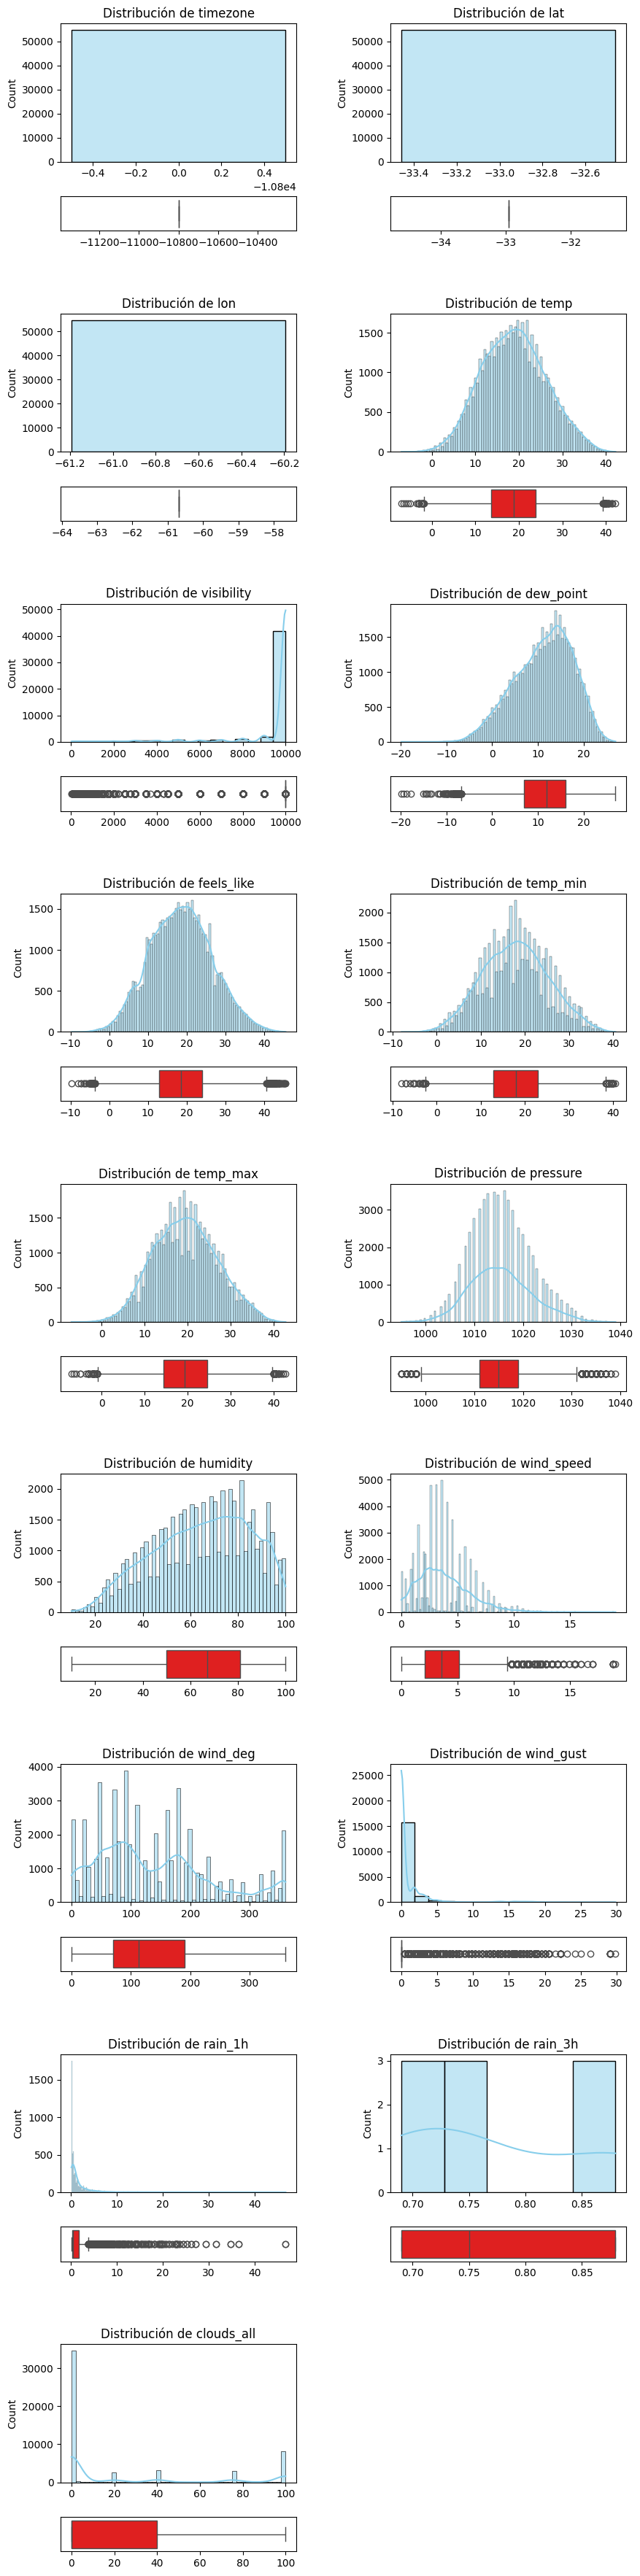

In [453]:


variables = df_tiempo.select_dtypes(include='number').columns
n_vars = len(variables)

# Cantidad de columnas en la grilla (por ejemplo, 2 columnas)
n_cols = 2
n_rows = int(np.ceil(n_vars / n_cols))

fig = plt.figure(figsize=(10, 5 * n_rows))

# Grid general
outer_grid = gridspec.GridSpec(n_rows, n_cols, wspace=0.4, hspace=0.4)

for i, var in enumerate(variables):
    row = i // n_cols
    col = i % n_cols
    inner_grid = gridspec.GridSpecFromSubplotSpec(
        2, 1, height_ratios=[4, 1],
        subplot_spec=outer_grid[i], hspace=0.4
    )

    # Histograma + KDE
    ax_top = plt.Subplot(fig, inner_grid[0])
    sns.histplot(df_tiempo[var], kde=True, ax=ax_top, color='skyblue')
    ax_top.set_title(f'Distribución de {var}')
    ax_top.set_xlabel('')
    fig.add_subplot(ax_top)

    # Boxplot
    ax_bottom = plt.Subplot(fig, inner_grid[1])
    sns.boxplot(x=df_tiempo[var], ax=ax_bottom, color='red')
    ax_bottom.set_yticks([])
    ax_bottom.set_xlabel('')
    fig.add_subplot(ax_bottom)

plt.tight_layout()
plt.show()


Por lo que podemos observar en los gráficos, la muchas de las variables numéricas presentan una distribución aproximadamente simétrica y baja cantidad de valores atípicos. Sin embargo, hay unas pocas que sí requerirán ser tratadas con otros métodos de resumen.

Las variables que admiten el uso de la media para su resumen gracias a su simetría son las siguientes:
- timezone
- lat
- lon
- temp
- dew_point
- feels_like
- temp_min
- temp_max
- pressure

Las variables que no poseen simetría o están sesgadas y, por lo tanto, deberán ser resumidas con la mediana son las siguientes:
- visibillity
- humidityu
- wind_speed
- wind_deg
- wind_gust
- rain_1h
- rain_3h
- clouds_all

En el caso de las variables categóricas, serán resumidas con la moda

Encontramos también ciertas columnas que solo tienen un valor dentro de ellas. Al ser constantes no serán útiles para la predicción.

In [454]:
columnasConUnSoloValor = []
for columna in df_tiempo.columns:
    if len(df_tiempo[columna].unique()) == 1:
        columnasConUnSoloValor.append(columna)


print("Columnas con un solo valor:")
print(columnasConUnSoloValor)



Columnas con un solo valor:
['timezone', 'city_name', 'lat', 'lon']


In [455]:
#Eliminamos columnas donde solo hay un valor
df_tiempo.drop(columnasConUnSoloValor, axis='columns', inplace=True)

In [456]:
#variables categoricas
df_tiempo.select_dtypes(include='object').columns

Index(['weather_main', 'weather_description', 'weather_icon'], dtype='object')

In [457]:
df_tiempo_agrupado = df_tiempo.groupby('dt_iso').agg({
    #Variables simétricas
    'temp': 'mean',
    'dew_point': 'mean',
    'feels_like': 'mean',
    'temp_min': 'min',
    'temp_max': 'max',
    'pressure': 'mean',

    #Variables asimétricas
    'visibility':'median',
    'humidity':'median',
    'wind_speed':'median',
    'wind_deg':'median',
    'wind_gust':'median',
    'rain_1h':'median',
    'rain_3h':'median',
    'clouds_all':'median',

    #Variables categóricas
    'weather_main': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,  # moda
    'weather_description': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,  # moda
    'weather_icon': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,  # moda
}).reset_index()

Ahora ya tenemos el dataset del tiempo agrupado, listo para ser combinado con el dataset de historial de ventas para formar un conjunto de datos que contenga toda la información.

In [458]:
df_tiempo_agrupado.tail()

,dt_iso,temp,dew_point,feels_like,temp_min,temp_max,pressure,visibility,humidity,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,clouds_all,weather_main,weather_description,weather_icon
2211,2025-01-27,29.112500,16.731667,29.689167,21.00,37.79,1007.875000,10000.0,50.5,3.070,61.0,0.0,NaN,NaN,1.0,Clear,sky is clear,01d
2212,2025-01-28,27.015417,19.212917,28.317500,20.42,34.30,1011.708333,10000.0,63.5,2.895,150.0,0.0,0.315,0.88,0.0,Clear,sky is clear,01n
2213,2025-01-29,27.885000,14.532500,27.445000,18.52,37.79,1014.500000,10000.0,68.0,2.570,125.5,0.0,NaN,NaN,0.0,Clear,sky is clear,01d
2214,2025-01-30,28.290417,17.700417,28.874583,20.42,35.57,1012.916667,10000.0,59.0,3.860,85.0,0.0,NaN,NaN,0.0,Clear,sky is clear,01d
2215,2025-01-31,27.858750,16.066250,27.842083,19.00,36.68,1009.583333,10000.0,60.5,4.070,90.0,0.0,NaN,NaN,0.0,Clear,sky is clear,01d


Ahora continuamos analizando el dataset de las ventas históricas.

In [459]:
df_historial.shape

(2033, 83)

In [460]:
df_historial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033 entries, 0 to 2032
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Ajuste Fecha    2033 non-null   datetime64[ns]
 1   Dia Semana      2033 non-null   object        
 2   Sabor 1         1803 non-null   object        
 3   Sabor 2         1090 non-null   object        
 4   Sabor 3         1853 non-null   object        
 5   Sabor 4         614 non-null    object        
 6   Sabor 5         516 non-null    object        
 7   Sabor 6         1676 non-null   object        
 8   Sabor 7         1778 non-null   object        
 9   Sabor 8         1652 non-null   object        
 10  Sabor 9         733 non-null    object        
 11  Sabor 10        1820 non-null   object        
 12  Sabor 11        1427 non-null   object        
 13  Sabor 12        883 non-null    object        
 14  Sabor 13        1842 non-null   object        
 15  Sabo

Comprobamos que no hayan días repetidos:

In [461]:
len(df_historial['Ajuste Fecha'].unique())

2033

Combinamos los dataset.

In [462]:
df = pd.merge(df_historial, df_tiempo_agrupado, left_on='Ajuste Fecha', right_on='dt_iso', how='left')

In [463]:
df.head()

,Ajuste Fecha,Dia Semana,Sabor 1,Sabor 2,Sabor 3,Sabor 4,Sabor 5,Sabor 6,Sabor 7,Sabor 8,...,humidity,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,clouds_all,weather_main,weather_description,weather_icon
0,2019-08-07,Lunes,"20,61","38,54","22,36","20,7","15,74","17,69","47,42","25,69",...,74.0,4.35,150.0,NaN,NaN,NaN,0.0,Clear,sky is clear,01n
1,2019-09-07,Martes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.0,3.10,150.0,NaN,0.130,NaN,0.0,Clear,sky is clear,01n
2,2019-10-07,Miércoles,NaN,"-5,56",NaN,NaN,NaN,NaN,NaN,NaN,...,62.0,4.10,320.0,NaN,NaN,NaN,0.0,Clear,sky is clear,01d
3,2019-12-07,Jueves,"-4,84",NaN,NaN,NaN,NaN,NaN,"-5,41",NaN,...,46.5,5.10,90.0,NaN,0.185,NaN,0.0,Clear,sky is clear,01d
4,2019-07-13,Viernes,"21,5","19,28","33,16","24,78","15,33",NaN,"37,62","12,44",...,89.0,2.60,150.0,NaN,NaN,NaN,0.0,Clear,sky is clear,01n


Se visualizarán la variación de las variables objetivos con respecto a la fecha para buscar tendencias.

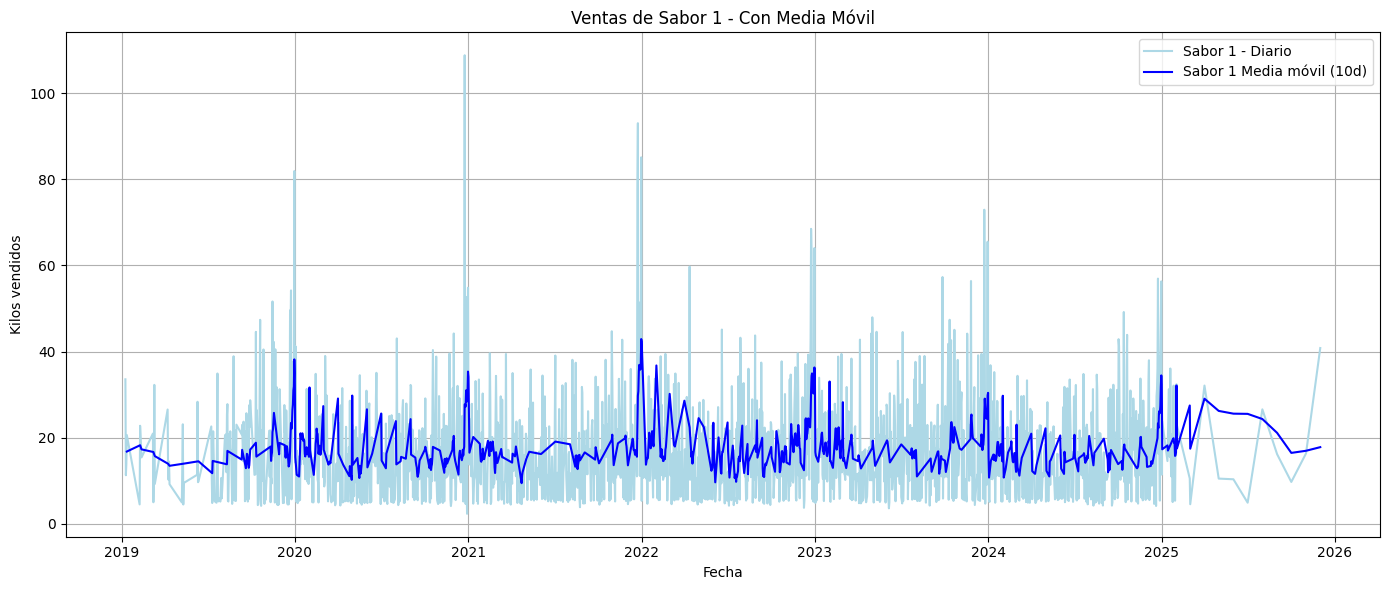

In [464]:
#Cambiar tipo de datos a float
sabor1 = df['Sabor 1'].str.replace('-', '').str.replace(',','.').astype(float)
#sabor2 = df['Sabor 2'].str.replace('-', '').str.replace(',','.').astype(float)

df['Ajuste Fecha'] = pd.to_datetime(df['Ajuste Fecha'])
df = df.sort_values(by='Ajuste Fecha')
sabor1_rolling = sabor1.rolling(window=10).mean()
#sabor2_rolling = sabor2.rolling(window=10).mean()

plt.figure(figsize=(14, 6))

sns.lineplot(x=df['Ajuste Fecha'], y=sabor1, label='Sabor 1 - Diario', color='lightblue')
sns.lineplot(x=df['Ajuste Fecha'], y=sabor1_rolling, label='Sabor 1 Media móvil (10d)', color='blue')

plt.title('Ventas de Sabor 1 - Con Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Kilos vendidos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2033 entries, 19 to 2010
Columns: 101 entries, Ajuste Fecha to weather_icon
dtypes: datetime64[ns](2), float64(33), object(66)
memory usage: 1.6+ MB


In [466]:
import pandas as pd
import plotly.graph_objects as go

# Asegurarte que las fechas estén en formato datetime
df['Ajuste Fecha'] = pd.to_datetime(df['Ajuste Fecha'])

# Ordenar por fecha
df = df.sort_values('Ajuste Fecha')

# Crear figura
fig = go.Figure()

# Crear lista de trazas y botones para cada sabor
botones = []
for i in range(1, 11):  # Sabores 1 al 10
    col = f'Sabor {i}'
    
    # Limpiar y convertir a float
    sabor = df[col].astype(str).str.replace('-', '').str.replace(',', '.').astype(float)
    
    # Calcular media móvil
    sabor_rolling = sabor.rolling(window=15, min_periods=1).mean()
    
    # Agregar traza diaria (inicialmente invisible)
    fig.add_trace(go.Scatter(
        x=df['Ajuste Fecha'], y=sabor,
        name=f'{col} Diario',
        visible=(i == 1),  # Solo mostrar el primer sabor por defecto
        line=dict(color='lightblue')
    ))
    
    # Agregar traza suavizada
    fig.add_trace(go.Scatter(
        x=df['Ajuste Fecha'], y=sabor_rolling,
        name=f'{col} Media Móvil',
        visible=(i == 1),
        line=dict(color='blue')
    ))
    
    # Botón para activar solo las trazas del sabor i
    visibilidad = [False] * 20  # 2 trazas por sabor × 10 sabores
    visibilidad[2 * (i - 1)] = True       # línea original
    visibilidad[2 * (i - 1) + 1] = True   # línea suavizada
    
    botones.append(dict(label=f'Sabor {i}',
                        method='update',
                        args=[{'visible': visibilidad},
                              {'title': f'Ventas de Sabor {i}'}]))

# Layout con el menú
fig.update_layout(
    updatemenus=[{
        'buttons': botones,
        'direction': 'down',
        'showactive': True,
        'x': 1.15,
        'xanchor': 'left',
        'y': 1,
        'yanchor': 'top'
    }],
    title='Ventas de Sabor 1',
    xaxis_title='Fecha',
    yaxis_title='Kilos vendidos',
    legend_title='Tipo de serie',
    height=500,
    width=1200
)

fig.show()


#### Comprobamos visualemente las ventas de los distintos sabores a lo largo del tiempo

El objetivo es poder definir grupos sobre los cuales actuarían modelos distintos. (distintos entrenamientos)

In [467]:
listaSabores = [f'Sabor {i}' for i in range(1, 80)]

In [468]:
listaSabores.append('Ajuste Fecha')

In [469]:
df_timeline = df[listaSabores]


In [470]:
def crear_constante(i, x):
    if pd.isna(x) or x == 0 or str(x).strip() == "":
        return None
    else:
        return i

In [471]:
for i in range(1,80):
    df_timeline[f'Sabor {i}'] = df_timeline[f'Sabor {i}'].apply(lambda x: crear_constante(i, x))

C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\4078931114.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [472]:
df_timeline

,Sabor 1,Sabor 2,Sabor 3,Sabor 4,Sabor 5,Sabor 6,Sabor 7,Sabor 8,Sabor 9,Sabor 10,...,Sabor 71,Sabor 72,Sabor 73,Sabor 74,Sabor 75,Sabor 76,Sabor 77,Sabor 78,Sabor 79,Ajuste Fecha
19,NaN,2.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08
50,1.0,2.0,3.0,4.0,NaN,NaN,7.0,8.0,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-09
80,1.0,2.0,3.0,4.0,5.0,NaN,7.0,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10
111,1.0,2.0,3.0,4.0,NaN,NaN,7.0,8.0,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-11
141,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,1.0,2.0,3.0,NaN,NaN,6.0,7.0,8.0,9.0,10.0,...,NaN,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,2025-08-01
2007,1.0,2.0,3.0,NaN,NaN,6.0,7.0,8.0,9.0,10.0,...,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,2025-09-01
2008,1.0,2.0,3.0,NaN,NaN,6.0,7.0,8.0,9.0,10.0,...,NaN,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,2025-10-01
2009,1.0,2.0,3.0,NaN,NaN,6.0,7.0,8.0,9.0,10.0,...,71.0,NaN,73.0,74.0,75.0,76.0,77.0,78.0,NaN,2025-11-01


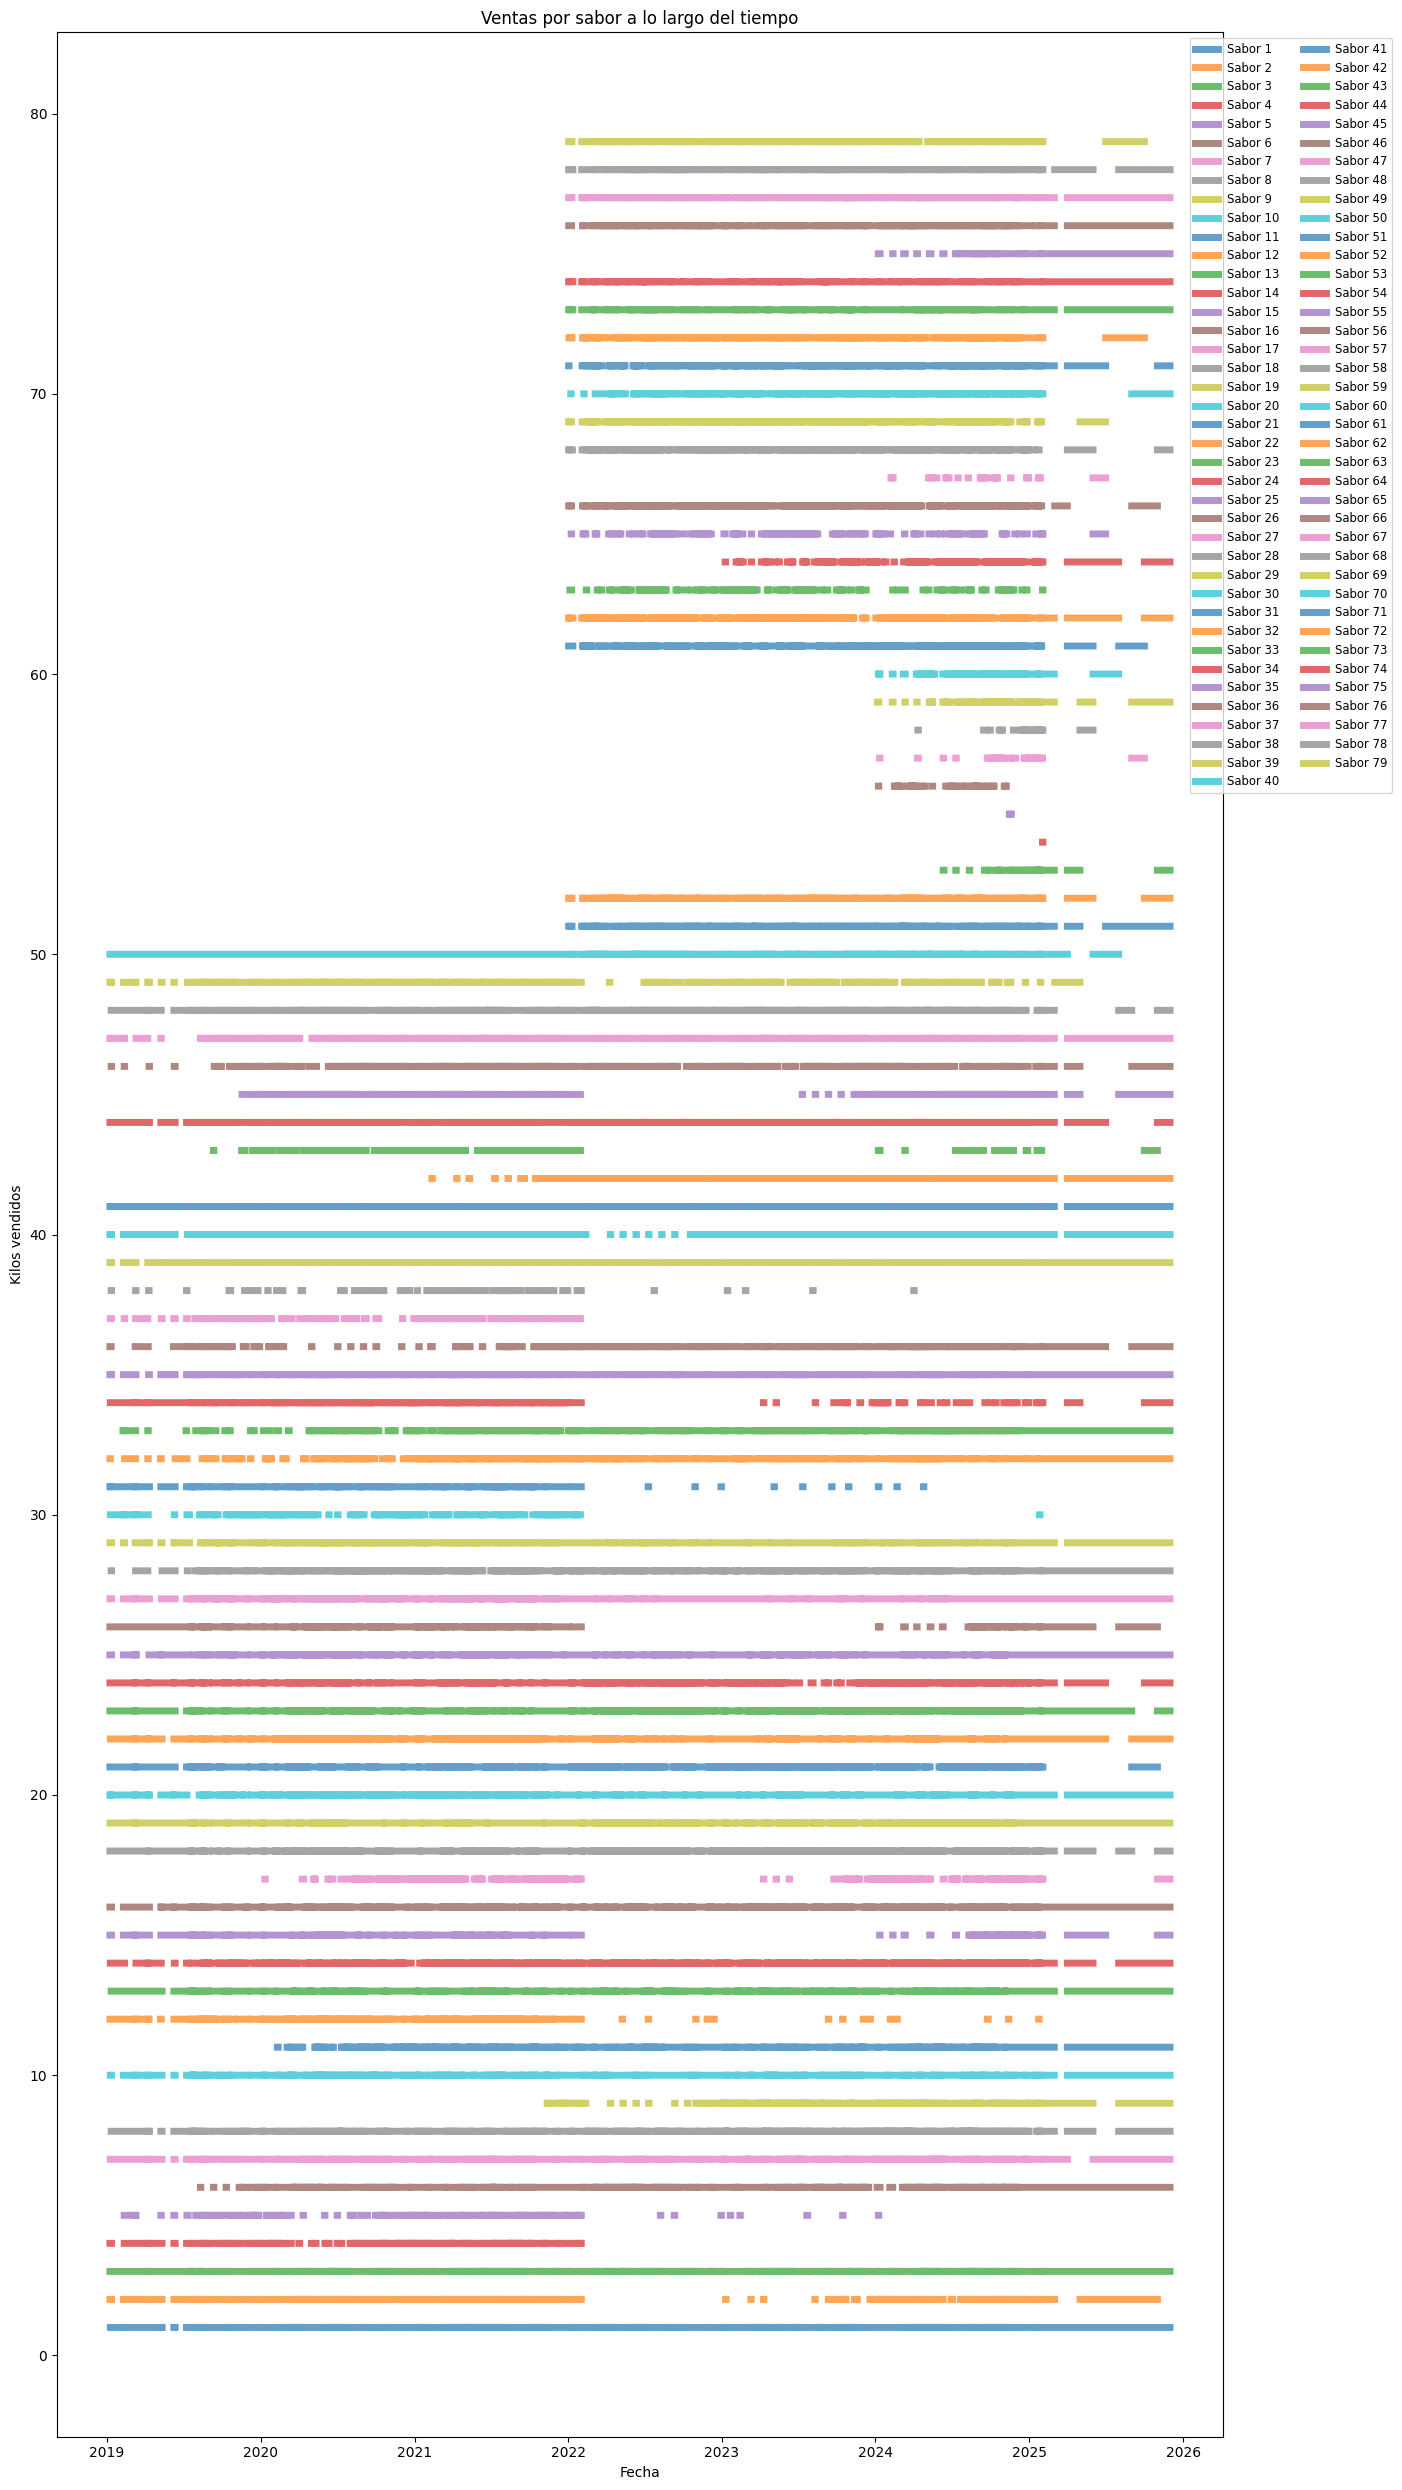

In [473]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 25))

# Graficar sabores del 1 al 80
for i in range(1, 81):  # NOTA: 81 porque el último no se incluye
    nombre_columna = f'Sabor {i}'
    if nombre_columna in df_timeline.columns:
        plt.plot(df_timeline['Ajuste Fecha'], df_timeline[nombre_columna], label=nombre_columna, alpha=0.7, linewidth=5)

plt.xlabel("Fecha")
plt.ylabel("Kilos vendidos")
plt.title("Ventas por sabor a lo largo del tiempo")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


A simple vista podemos encontrar un patrón:
- Hay sabores cuya venta nunca se detuvo.
- Hay sabores que se venden desde el inicio del registro de los datos pero tuvieron meses o años sin vender.
- Hay sabores que comenzaron a venderse a partir del año 2022.
- Hay sabores que se vendieron hasta el año 2022.
- Hay sabores cuyos registros son muy escasos (alrededor de dos años de venta).

Para cada uno de estos casos se me ocurrió realizar entrenamientos distintos.

##### Cambio de tipo de variables objetivo

In [474]:
#Intentamos convertir los sabores a float y encontramos que hay errores
for i in range(1,80):
    try:
        df[f'Sabor {i}'].astype(float)
    except:
        print(f"Error en Sabor {i}")

Error en Sabor 1
Error en Sabor 2
Error en Sabor 3
Error en Sabor 4
Error en Sabor 5
Error en Sabor 6
Error en Sabor 7
Error en Sabor 8
Error en Sabor 9
Error en Sabor 10
Error en Sabor 11
Error en Sabor 12
Error en Sabor 13
Error en Sabor 14
Error en Sabor 15
Error en Sabor 16
Error en Sabor 17
Error en Sabor 18
Error en Sabor 19
Error en Sabor 20
Error en Sabor 21
Error en Sabor 22
Error en Sabor 23
Error en Sabor 24
Error en Sabor 25
Error en Sabor 26
Error en Sabor 27
Error en Sabor 28
Error en Sabor 29
Error en Sabor 30
Error en Sabor 31
Error en Sabor 32
Error en Sabor 33
Error en Sabor 34
Error en Sabor 35
Error en Sabor 36
Error en Sabor 37
Error en Sabor 39
Error en Sabor 40
Error en Sabor 41
Error en Sabor 42
Error en Sabor 43
Error en Sabor 44
Error en Sabor 45
Error en Sabor 46
Error en Sabor 47
Error en Sabor 48
Error en Sabor 49
Error en Sabor 50
Error en Sabor 51
Error en Sabor 52
Error en Sabor 53
Error en Sabor 62
Error en Sabor 70
Error en Sabor 71
Error en Sabor 72
E

In [475]:
import re 
def es_alfabetico(valor):
    '''
    Esta función comprueba que no hayan cadenas de texto en los datos. Si las hay, devuelve None
    '''
    if not isinstance(valor, str):
        valor = str(valor)

    if bool(re.fullmatch(r'[a-zA-Z]+', valor.strip())):
        return None
    else:
        return valor

#Con esta función implementada y limpiando un poco los valores no tenemos ningún error
for i in range(1,80):
    try:
        df[f'Sabor {i}'].astype(str).str.replace('-', '').str.replace('.', 'n').str.replace(',', '.').str.replace('n', '').apply(lambda x: es_alfabetico(x))
    except:
        print(f"Error en Sabor {i}")


In [476]:
#Aplicamos la conversion de datos a todos los sabores
for i in range(1, 80):
    try:
        df[f'Sabor {i}'] = df[f'Sabor {i}'].astype(str).str.replace('-', '').str.replace('.', 'n').str.replace(',', '.').str.replace('n', '').apply(lambda x: es_alfabetico(x)).astype(float)
    except:
        print(f"Error en Sabor {i}")

In [477]:
df["Total Cantidad Kilos"]=df[df.iloc[:, 2:81].columns].sum(axis = 1) #Suma de todos los sabores

In [478]:
df['Total Cantidad Kilos']

19       501.76
50      2287.92
80       417.12
111     1471.46
141     2037.46
         ...   
2006     964.32
2007    2123.08
2008    1857.12
2009    1744.75
2010    4395.03
Name: Total Cantidad Kilos, Length: 2033, dtype: float64

In [479]:
media = df[df.iloc[:, 2:81].columns].mean(axis = 1) 
mediana = df[df.iloc[:, 2:81].columns].median(axis = 1)
suma = df[df.iloc[:, 2:81].columns].sum(axis = 1)

Text(0.5, 1.0, 'Ventas Totales de Helados')

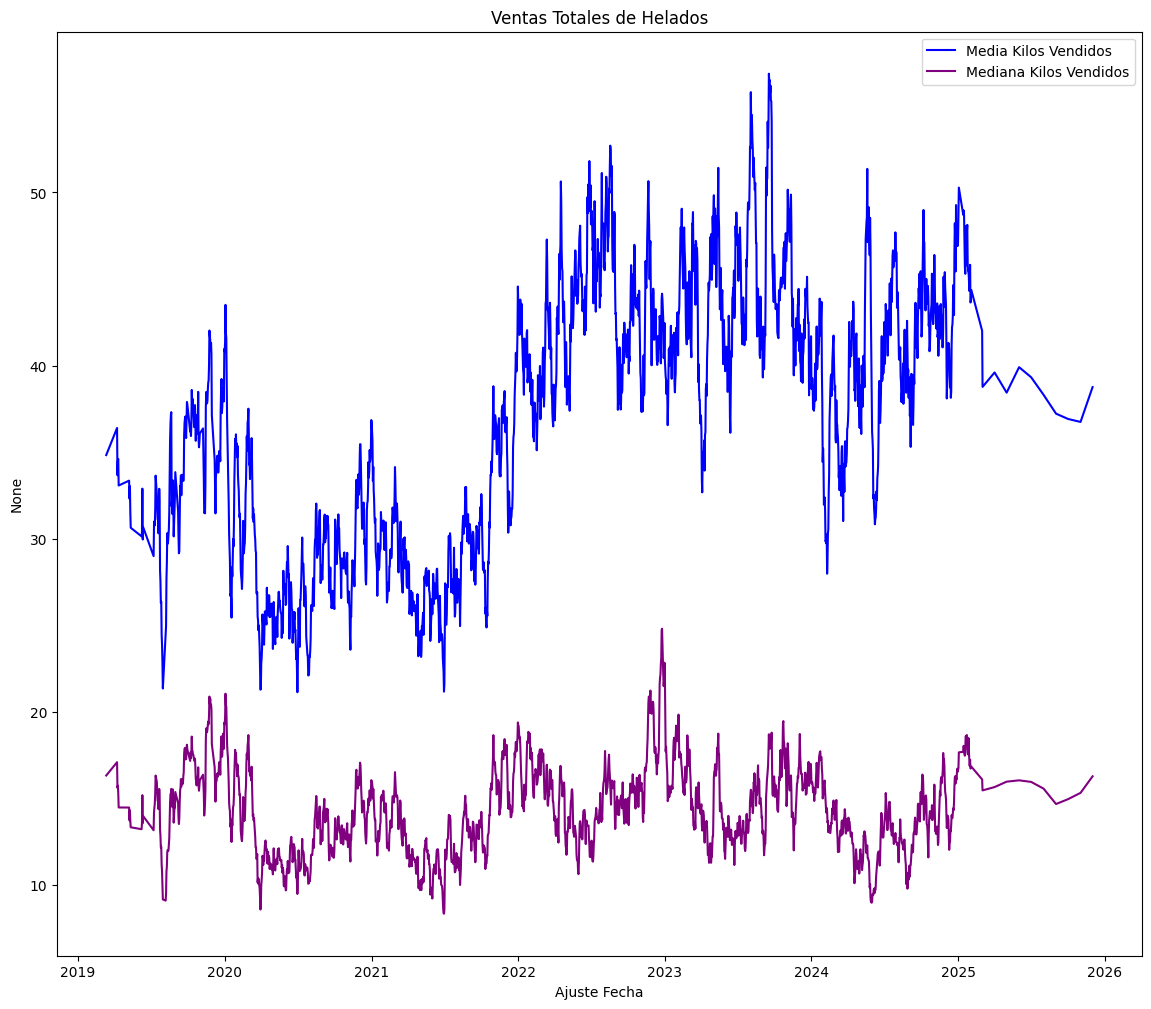

In [480]:
plt.figure(figsize=(14, 12))

#sns.lineplot(x=df['Ajuste Fecha'], y=df['Total Cantidad Kilos'], color='skyblue')
#rolling
sabor_rolling = media.rolling(window=15).mean()
sns.lineplot(x=df['Ajuste Fecha'], y=sabor_rolling, label='Media Kilos Vendidos', color='blue')


rolling_mediana = mediana.rolling(window=15).mean()
sns.lineplot(x=df['Ajuste Fecha'], y=rolling_mediana, label='Mediana Kilos Vendidos', color='purple')

plt.title('Ventas Totales de Helados')

#### Matriz de correlación con respecto a algunas variables objetivo

In [481]:
columnas = ['temp', 'dew_point', 'feels_like',
       'temp_min', 'temp_max', 'pressure', 'visibility', 'humidity',
       'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h', 'rain_3h',
       'clouds_all', 'Sabor 1', 'Sabor 2', 'Sabor 3', 'Sabor 4']

In [482]:
#solo variable snumericas
numericas = df.select_dtypes(include='number').columns
correlacion = df[columnas].corr(method='spearman')  # También podés usar 'spearman' o 'kendall'
print(correlacion)


                temp  dew_point  feels_like  temp_min  temp_max  pressure  \
temp        1.000000   0.837339    0.997848  0.924040  0.946582 -0.675145   
dew_point   0.837339   1.000000    0.866562  0.912688  0.711888 -0.677856   
feels_like  0.997848   0.866562    1.000000  0.936112  0.937165 -0.685052   
temp_min    0.924040   0.912688    0.936112  1.000000  0.782262 -0.717940   
temp_max    0.946582   0.711888    0.937165  0.782262  1.000000 -0.593329   
pressure   -0.675145  -0.677856   -0.685052 -0.717940 -0.593329  1.000000   
visibility  0.104675  -0.124669    0.085258 -0.031163  0.167664  0.068303   
humidity   -0.223942   0.283781   -0.175793 -0.000856 -0.318195 -0.053548   
wind_speed  0.077844   0.044002    0.066042  0.183156 -0.023424 -0.162433   
wind_deg   -0.209156  -0.197581   -0.211465 -0.178260 -0.231916  0.023233   
wind_gust  -0.083654  -0.051709   -0.081104 -0.050861 -0.106668 -0.023042   
rain_1h     0.116521   0.167117    0.120981  0.152321  0.099087 -0.179688   

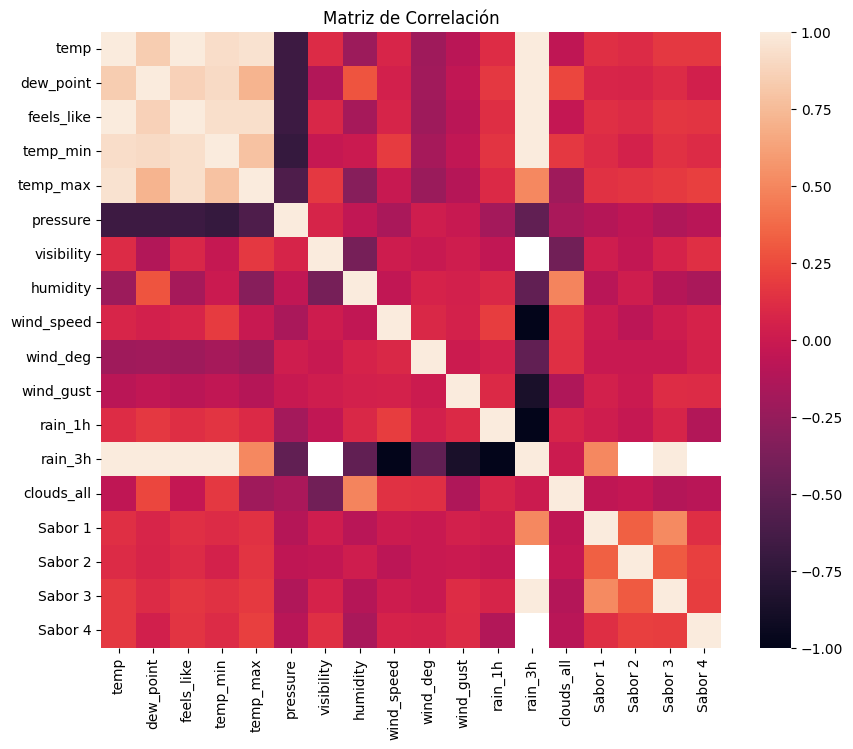

In [483]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=False)
plt.title("Matriz de Correlación")
plt.show()


#### Formatear dataframe

Actualmente el dataframe se encuentra en la siguiente estructura:

| Fecha      | x1 | x2 | Sabor 1 | Sabor 2 | Sabor 3 |
|------------|----|----|---------|---------|---------|
| 11/04/2025 | 5  | 4  | 54      | 23      | 12      |


Esto genera la problemática de múltiples variables objetivo, para lo que tendríamos que tener varios modelos entrenados por separado (uno para cada sabor o grupo de sabores). Pero esta no es la única opción, puesto a que también podemos tomar el sabor como categoría y que la variable objetivo sea simplemente los kg vendidos, de la siguiente manera:

| Fecha      | x1 | x2 | Sabor   | Kg |
|------------|----|----|---------|----|
| 11/04/2025 | 5  | 4  | Sabor 1 | 54 |
| 11/04/2025 | 5  | 4  | Sabor 2 | 23 |
| 11/04/2025 | 5  | 4  | Sabor 3 | 12 |


Este formato permitiría simplificar un poco la elección de los modelos, a la vez que supondría un aumento considerable de los datos para predecir.

El único problema de este enfoque probablemente sea el balanceo del dataset: al haber tan pocas ventas de muchos de los sabores, el dataset quedará desbalanceado. Siendo necesario un sobre o submuestreo, según corresponda.

In [484]:
#sabores
df_sabores = df.iloc[:, 2:81]

In [485]:
df_melt = df.melt(id_vars=['Ajuste Fecha',  'Dia Semana','dt_iso', 'temp',
       'dew_point', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'visibility', 'humidity', 'wind_speed', 'wind_deg', 'wind_gust',
       'rain_1h', 'rain_3h', 'clouds_all', 'weather_main',
       'weather_description', 'weather_icon'], value_vars=df_sabores.columns, var_name='Sabor', value_name='Kg')
df_melt.head()

,Ajuste Fecha,Dia Semana,dt_iso,temp,dew_point,feels_like,temp_min,temp_max,pressure,visibility,...,wind_deg,wind_gust,rain_1h,rain_3h,clouds_all,weather_main,weather_description,weather_icon,Sabor,Kg
0,2019-01-08,Sábado,2019-01-08,25.666667,19.623333,27.085000,18.99,32.17,1006.500000,10000.0,...,295.0,NaN,NaN,NaN,0.0,Clear,sky is clear,01n,Sabor 1,NaN
1,2019-01-09,Martes,2019-01-09,26.542500,20.844583,27.634167,22.99,30.01,1005.333333,9999.5,...,90.0,1.790,0.340,NaN,0.0,Rain,sky is clear,10d,Sabor 1,33.57
2,2019-01-10,Jueves,2019-01-10,21.285417,17.422917,21.536667,17.99,24.39,1013.125000,9999.0,...,160.0,2.905,0.445,NaN,75.0,Clouds,light rain,04d,Sabor 1,11.31
3,2019-01-11,Domingo,2019-01-11,19.796250,13.380417,19.645000,11.99,28.90,1019.166667,9999.5,...,140.0,5.360,NaN,NaN,10.0,Clear,sky is clear,01n,Sabor 1,13.95
4,2019-01-12,Martes,2019-01-12,25.040417,18.125000,25.817917,18.90,32.73,1014.416667,10000.0,...,50.0,NaN,0.160,NaN,0.0,Clear,sky is clear,01n,Sabor 1,20.64


In [486]:
df_historial.iloc[:, 2:81].isnull().sum()

Sabor 1      230
Sabor 2      943
Sabor 3      180
Sabor 4     1419
Sabor 5     1517
            ... 
Sabor 75    1851
Sabor 76    1229
Sabor 77    1185
Sabor 78    1118
Sabor 79    1235
Length: 79, dtype: int64

In [487]:
df_melt.isnull().sum()

Ajuste Fecha                0
Dia Semana                  0
dt_iso                   1027
temp                     1027
dew_point                1027
feels_like               1027
temp_min                 1027
temp_max                 1027
pressure                 1027
visibility               1027
humidity                 1027
wind_speed               1027
wind_deg                 1027
wind_gust               30652
rain_1h                107361
rain_3h                160370
clouds_all               1027
weather_main             1027
weather_description      1027
weather_icon             1027
Sabor                       0
Kg                      78130
dtype: int64

In [488]:
df.columns

Index(['Ajuste Fecha', 'Dia Semana', 'Sabor 1', 'Sabor 2', 'Sabor 3',
       'Sabor 4', 'Sabor 5', 'Sabor 6', 'Sabor 7', 'Sabor 8',
       ...
       'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h', 'rain_3h',
       'clouds_all', 'weather_main', 'weather_description', 'weather_icon',
       'Total Cantidad Kilos'],
      dtype='object', length=102)

In [489]:
#Elimino los totales
df_melt = df_melt[df_melt['Sabor'] != 'Total Cantidad Kilos']

In [490]:
#Exportar a csv
#df_melt.to_csv('helados-melt.csv', sep=';', index=False)

#### Agregar días feriados o no laborables

La información acerca de los días no laborables podría ser muy útil a la hora de realizar un análisis de la venta de helado. Partimos de la hipótesis de que los días no laborables las ventas de helado aumentan.

In [491]:
#!pip install holidays

In [492]:
df_melt.columns

Index(['Ajuste Fecha', 'Dia Semana', 'dt_iso', 'temp', 'dew_point',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'visibility',
       'humidity', 'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h', 'rain_3h',
       'clouds_all', 'weather_main', 'weather_description', 'weather_icon',
       'Sabor', 'Kg'],
      dtype='object')

In [493]:
import holidays

# Si solo querés nacionales:
ar_holidays = holidays.country_holidays("ARG")           # desde 1900 hasta 2099 aprox.

In [494]:
from datetime import date

def parsear_feriado(x):
    '''
    Esta función recibe una fecha y devuelve True si es feriado, False si no lo es.
    Si la fecha es nula, devuelve None.
    '''
    if pd.isna(x):  # Verifica si el valor es nulo
        return None
    year = x.year
    month = x.month
    day = x.day
    fecha = date(year, month, day)
    if fecha in ar_holidays:
        return True
    else:
        return False

In [495]:
def parsear_motivo_feriado(x):
    '''
    Esta función recibe una fecha y devuelve el motivo del feriado.

    '''
    year = x.year
    month = x.month
    day = x.day
    fecha = date(year, month, day)
    if fecha in ar_holidays:
        return ar_holidays[fecha]
    else:
        return None

In [496]:
 df_melt['dt_iso'] 

0        2019-01-08
1        2019-01-09
2        2019-01-10
3        2019-01-11
4        2019-01-12
            ...    
160602          NaT
160603          NaT
160604          NaT
160605          NaT
160606          NaT
Name: dt_iso, Length: 160607, dtype: datetime64[ns]

In [497]:
df_melt['dt_iso'] = pd.to_datetime(df_melt['dt_iso'])
df_melt['es_feriado'] = df_melt['dt_iso'].apply(lambda x: parsear_feriado(x))
#df_melt['feriado_nombre'] = df_melt['dt_iso'].apply(lambda x: parsear_motivo_feriado(x))

In [498]:
#Eliminar feriado_nombre
#df_melt.drop(['feriado_nombre'], axis='columns', inplace=True)


#### Agregar Estaciones del Año

In [499]:
# Definir una función para determinar la estación del año en Argentina
def obtener_estacion(fecha):
    '''
    Esta función recibe una fecha y devuelve la estación correspondiente en Argentina.
    '''
    if pd.isna(fecha):  # Manejar valores nulos
        return None
    mes = fecha.month
    dia = fecha.day

    if (mes == 12 and dia >= 21) or (mes in [1, 2]) or (mes == 3 and dia < 21):
        return 'Verano'
    elif (mes == 3 and dia >= 21) or (mes in [4, 5]) or (mes == 6 and dia < 21):
        return 'Otoño'
    elif (mes == 6 and dia >= 21) or (mes in [7, 8]) or (mes == 9 and dia < 21):
        return 'Invierno'
    elif (mes == 9 and dia >= 21) or (mes in [10, 11]) or (mes == 12 and dia < 21):
        return 'Primavera'

# Crear la columna 'estacion' en el DataFrame
df_melt['estacion'] = df_melt['dt_iso'].apply(obtener_estacion)

# Verificar los resultados
df_melt[['dt_iso', 'estacion']].head()

,dt_iso,estacion
0,2019-01-08,Verano
1,2019-01-09,Verano
2,2019-01-10,Verano
3,2019-01-11,Verano
4,2019-01-12,Verano


C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\250909624.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='estacion', ylabel='count'>

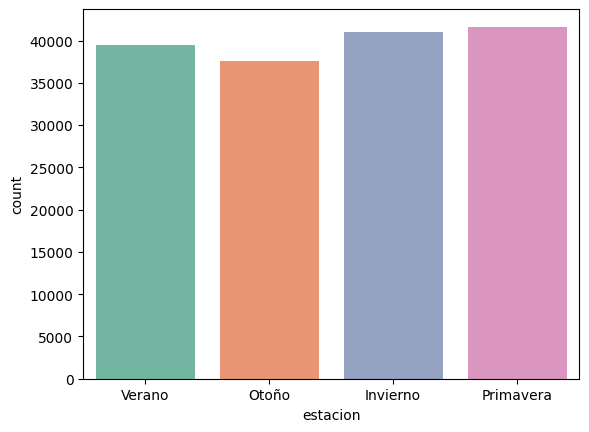

In [500]:
sns.countplot(data=df_melt, x='estacion', palette='Set2')

## 2. División del Conjunto de Datos

Ahora que ya tenemos un dataframe un poco más sólido es hora de dividir el dataset para comenzar a trabajar con la limpieza del conjunto de entrenamiento.

Las funciones que se utilicen para limpiar el conjunto de entrenamiento serán las que se utilizarán luego al obtener datos reales.

In [501]:
print(df_melt['dt_iso'].min())
print(df_melt['dt_iso'].max())

2019-01-08 00:00:00
2025-01-31 00:00:00


Sabemos por el análisis previamente realizado que una buena cantidad de sabores (a partir del sabor 50) solo poseen datos a partir del año 2022. Por ello, buscando obtener un dataset balanceado, utilizaremos los datos a partir de dicho año.

Por otro lado, el dataset posee también información sobre fechas mayores a la actual y consideramos que puede deberse a un error humano. Por ello tomaremos solo hasta fin del año 2024.

In [502]:
# Filtramos df_melt
df_melt[(df_melt['dt_iso'].dt.year >= 2022) & (df_melt['dt_iso'].dt.year <= 2024)]

,Ajuste Fecha,Dia Semana,dt_iso,temp,dew_point,feels_like,temp_min,temp_max,pressure,visibility,...,rain_1h,rain_3h,clouds_all,weather_main,weather_description,weather_icon,Sabor,Kg,es_feriado,estacion
903,2022-01-01,Lunes,2022-01-01,25.950400,17.770800,26.337200,21.34,32.17,1002.680000,10000.0,...,0.51,NaN,40.0,Clouds,sky is clear,01n,Sabor 1,5.36,True,Verano
904,2022-01-02,Jueves,2022-01-02,25.956667,19.792500,27.260417,17.88,34.43,1004.541667,10000.0,...,0.51,NaN,0.5,Clear,sky is clear,01d,Sabor 1,22.92,False,Verano
905,2022-01-03,Jueves,2022-01-03,28.290400,20.256400,29.739200,21.00,35.81,1006.760000,10000.0,...,3.30,NaN,0.0,Clear,sky is clear,01d,Sabor 1,34.39,False,Verano
906,2022-01-04,Domingo,2022-01-04,26.944615,19.070385,27.760385,20.08,33.34,1006.153846,10000.0,...,1.90,NaN,0.0,Clear,sky is clear,01d,Sabor 1,10.66,False,Verano
907,2022-01-05,Martes,2022-01-05,24.381250,11.405833,23.972917,16.75,31.68,1013.750000,10000.0,...,NaN,NaN,0.0,Clear,sky is clear,01d,Sabor 1,11.42,False,Verano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160568,2024-12-27,Domingo,2024-12-27,22.339167,13.905833,22.171667,13.34,30.42,1013.083333,10000.0,...,NaN,NaN,0.0,Clear,sky is clear,01d,Sabor 79,19.73,False,Verano
160569,2024-12-28,Lunes,2024-12-28,24.437500,13.805833,24.198750,15.00,32.17,1016.666667,10000.0,...,NaN,NaN,0.0,Clear,sky is clear,01d,Sabor 79,4.43,False,Verano
160570,2024-12-29,Martes,2024-12-29,24.166250,13.640417,23.967500,13.75,32.64,1015.708333,10000.0,...,NaN,NaN,0.0,Clear,sky is clear,01d,Sabor 79,15.40,False,Verano
160571,2024-12-30,Miércoles,2024-12-30,25.622917,15.534583,25.728333,18.00,35.57,1011.958333,10000.0,...,NaN,NaN,0.0,Clear,sky is clear,01d,Sabor 79,4.48,False,Verano


In [503]:
#Nos quedamos solo con las fechas que tienen datos
df_melt = df_melt[df_melt['dt_iso'].isnull() == False]
#df_melt.drop(columns=['Ajuste Fecha'], inplace=True)
df_melt.head()

,Ajuste Fecha,Dia Semana,dt_iso,temp,dew_point,feels_like,temp_min,temp_max,pressure,visibility,...,rain_1h,rain_3h,clouds_all,weather_main,weather_description,weather_icon,Sabor,Kg,es_feriado,estacion
0,2019-01-08,Sábado,2019-01-08,25.666667,19.623333,27.085000,18.99,32.17,1006.500000,10000.0,...,NaN,NaN,0.0,Clear,sky is clear,01n,Sabor 1,NaN,False,Verano
1,2019-01-09,Martes,2019-01-09,26.542500,20.844583,27.634167,22.99,30.01,1005.333333,9999.5,...,0.340,NaN,0.0,Rain,sky is clear,10d,Sabor 1,33.57,False,Verano
2,2019-01-10,Jueves,2019-01-10,21.285417,17.422917,21.536667,17.99,24.39,1013.125000,9999.0,...,0.445,NaN,75.0,Clouds,light rain,04d,Sabor 1,11.31,False,Verano
3,2019-01-11,Domingo,2019-01-11,19.796250,13.380417,19.645000,11.99,28.90,1019.166667,9999.5,...,NaN,NaN,10.0,Clear,sky is clear,01n,Sabor 1,13.95,False,Verano
4,2019-01-12,Martes,2019-01-12,25.040417,18.125000,25.817917,18.90,32.73,1014.416667,10000.0,...,0.160,NaN,0.0,Clear,sky is clear,01n,Sabor 1,20.64,False,Verano


In [504]:
print("Porcentaje de valores nulos por columna:")
print(df_melt.isnull().sum().apply(lambda x: x / len(df_melt)))

Porcentaje de valores nulos por columna:
Ajuste Fecha           0.000000
Dia Semana             0.000000
dt_iso                 0.000000
temp                   0.000000
dew_point              0.000000
feels_like             0.000000
temp_min               0.000000
temp_max               0.000000
pressure               0.000000
visibility             0.000000
humidity               0.000000
wind_speed             0.000000
wind_deg               0.000000
wind_gust              0.185644
rain_1h                0.666337
rain_3h                0.998515
clouds_all             0.000000
weather_main           0.000000
weather_description    0.000000
weather_icon           0.000000
Sabor                  0.000000
Kg                     0.487611
es_feriado             0.000000
estacion               0.000000
dtype: float64


In [505]:
X = df_melt.drop(columns=['Kg'])
y = df_melt['Kg']

In [506]:
#Dividimos el conjunto de datos
indice_corte = int(len(X) * 0.8) #El indice de corte es el correspondiente al 80% de los datos

X_train = X.iloc[:indice_corte]
y_train = y.iloc[:indice_corte]

X_test = X.iloc[indice_corte:]
y_test = y.iloc[indice_corte:]

#### Valores Nulos

In [507]:
X_train.shape

(127664, 23)

In [508]:
print("Proporción de valores nulos sobre el total del dataset")
print(X_train.isnull().sum().apply(lambda x: str(round(x / len(X_train) * 100, 2)) + "% del Dataset").sort_values(ascending=False))

Proporción de valores nulos sobre el total del dataset
rain_3h                99.85% del Dataset
rain_1h                66.64% del Dataset
wind_gust              18.58% del Dataset
Ajuste Fecha             0.0% del Dataset
wind_deg                 0.0% del Dataset
es_feriado               0.0% del Dataset
Sabor                    0.0% del Dataset
weather_icon             0.0% del Dataset
weather_description      0.0% del Dataset
weather_main             0.0% del Dataset
clouds_all               0.0% del Dataset
wind_speed               0.0% del Dataset
Dia Semana               0.0% del Dataset
humidity                 0.0% del Dataset
visibility               0.0% del Dataset
pressure                 0.0% del Dataset
temp_max                 0.0% del Dataset
temp_min                 0.0% del Dataset
feels_like               0.0% del Dataset
dew_point                0.0% del Dataset
temp                     0.0% del Dataset
dt_iso                   0.0% del Dataset
estacion             

Observamos que son cuatro las variables que poseen valores nulos, particularmente hay cuatro de ellas que poseen un porcentaje de valores nulos mayor al 15% del total del dataset.

En el caso de rain_1h y rain_3h, sus valores nulos indican la ausencia de lluvia lo cual puede ser un indicador valioso. Por ello se reemplazarán por 0.

In [509]:
X_train.drop(columns=['weather_icon'], inplace=True)
X_train.drop(columns=['Ajuste Fecha','dt_iso'], inplace=True)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\2605460007.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\2605460007.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [510]:
# Rellenamos nulos de rain_1h y rain_3h con 0
# X_train['rain_1h'].fillna(0, inplace=True)
# X_train['rain_3h'].fillna(0, inplace=True)
# X_test['rain_1h'].fillna(0, inplace=True)
# X_test['rain_3h'].fillna(0, inplace=True)

# Eliminamos variables feriado_nombre y wind_gust
#X_train.drop(columns=['wind_gust'], inplace=True)
#X_test.drop(columns=['wind_gust'], inplace=True)

# Eliminamos variables que no afectan al problema
X_train.drop(columns=['weather_description'], inplace=True)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\2876948149.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Escala logaítmica para Visibility y rain_1h

<Axes: xlabel='visibility', ylabel='Count'>

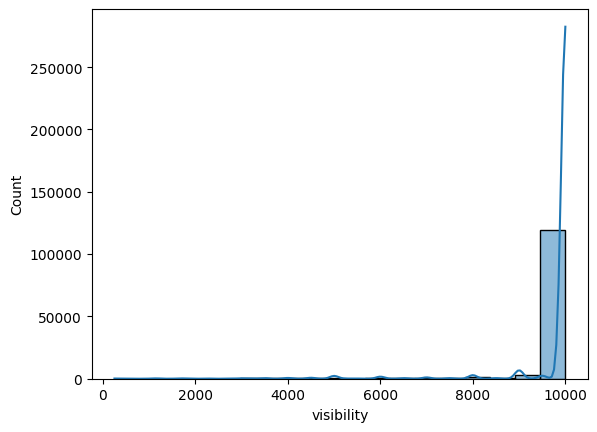

In [511]:
# graficar distiribucion de visibility
sns.histplot(X_train.visibility, kde=True)


In [512]:
X_train.visibility = np.log(X_train.visibility)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\572481557.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='rain_1h', ylabel='Count'>

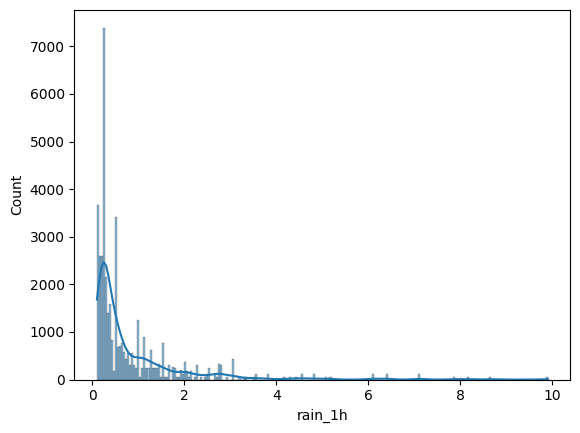

In [513]:
sns.histplot(X_train.rain_1h, kde=True)


<Axes: xlabel='rain_1h', ylabel='Count'>

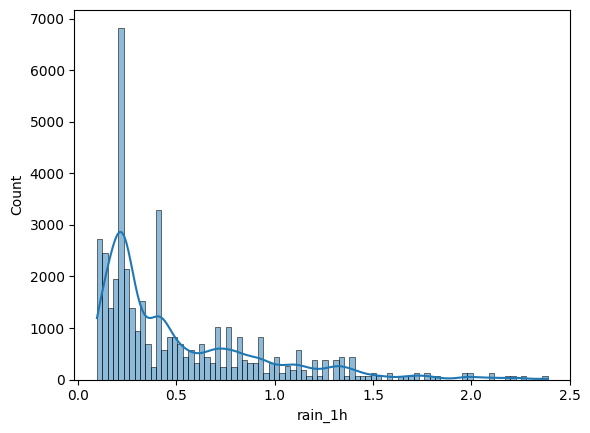

In [514]:
sns.histplot(np.log1p(X_train.rain_1h), kde=True)

In [515]:
X_train.rain_1h = np.log1p(X_train.rain_1h)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\559173434.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='wind_gust', ylabel='Count'>

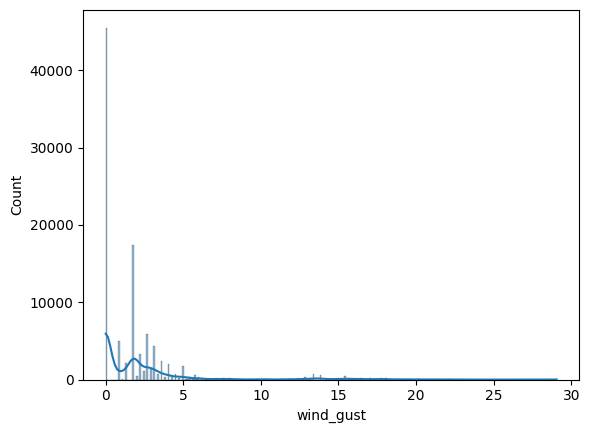

In [516]:
sns.histplot(X_train.wind_gust, kde=True)

<Axes: xlabel='wind_gust', ylabel='Count'>

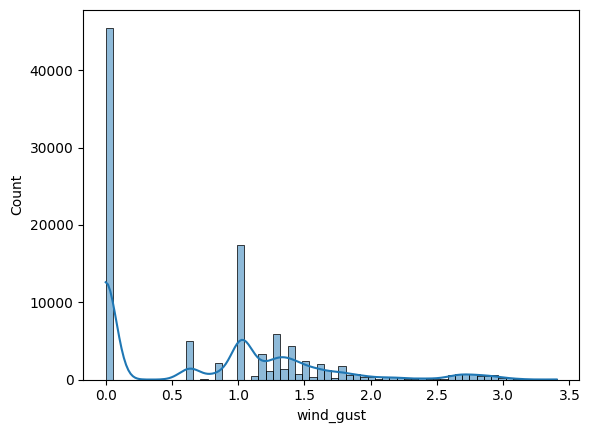

In [517]:
sns.histplot(np.log1p(X_train.wind_gust), kde=True) #np.log1p aplica log(1+x) para evitar problemas con ceros

In [518]:
X_train.wind_gust = np.log1p(X_train.wind_gust)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_5996\647653572.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Crear Pipeline

In [519]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

#------------ Grupos ----------------
num_zero = ['rain_1h', 'rain_3h']
num_mean = ['temp', 'dew_point', 'feels_like', 'temp_min', 'temp_max', 'pressure',
            'visibility', 'humidity', 'wind_speed', 'wind_deg', 'wind_gust',
            'clouds_all']
cat_mode = ['weather_main', 'Dia Semana', 'es_feriado', 'Sabor', 'estacion']

# ----------- Sub-pipelines ---------
zero_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', RobustScaler())

])

mean_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

mode_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ---------- Column transformer ----------
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num_zero', zero_pipe, num_zero),
        ('num_mean', mean_pipe, num_mean),
        ('cat_mode', mode_pipe, cat_mode)
    ],
    remainder='passthrough',  # Mantener columnas no transformadas sin prefijos
     verbose_feature_names_out=False  # No agregar prefijos a los nombres de las columnas
)

# ---------- Pipeline --------------
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_zero',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['rain_1h', 'rain_3h']),
                                                 ('num_mean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['temp', 'dew_point',
                                                   'feels_like', 'temp_min',
                                                   'temp_max', 'pressure',
                                                   'visibility', 'humidity',
                                                   'wind_speed', 'wind_deg',
                                                   'wind_gust', 'clouds_all']),
                                                 ('cat_mode',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weather_main', 'Dia Semana',
                                                   'es_feriado', 'Sabor',
                                                   'estacion'])],
                                   verbose_feature_names_out=False))])

In [520]:
X_train_tr = pipeline.named_steps['preprocessor'].transform(X_train)

# Obtener los nombres de las columnas generadas
column_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Mostrar los nombres de las columnas
#print(column_names)

X_train_tr = X_train_tr.toarray()

X_train_tr = pd.DataFrame(X_train_tr, columns=column_names)

X_train_tr.head()

,rain_1h,rain_3h,temp,dew_point,feels_like,temp_min,temp_max,pressure,visibility,humidity,...,Sabor_Sabor 62,Sabor_Sabor 63,Sabor_Sabor 64,Sabor_Sabor 7,Sabor_Sabor 8,Sabor_Sabor 9,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano
0,0.000000,0.0,0.676409,0.911399,0.784951,0.633919,0.590326,-1.063278,0.00000,0.139535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.311575,0.0,0.768239,1.053384,0.837929,1.047570,0.377098,-1.208506,-0.00005,0.348837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.649653,0.0,0.217038,0.655573,0.249699,0.530507,-0.177690,-0.238589,-0.00010,0.674419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.0,0.060900,0.185583,0.067208,-0.089969,0.267522,0.513485,-0.00005,0.232558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.665132,0.0,0.610747,0.737199,0.662714,0.624612,0.645607,-0.077801,0.00000,0.046512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Distribución de variables numéricas transformadas')

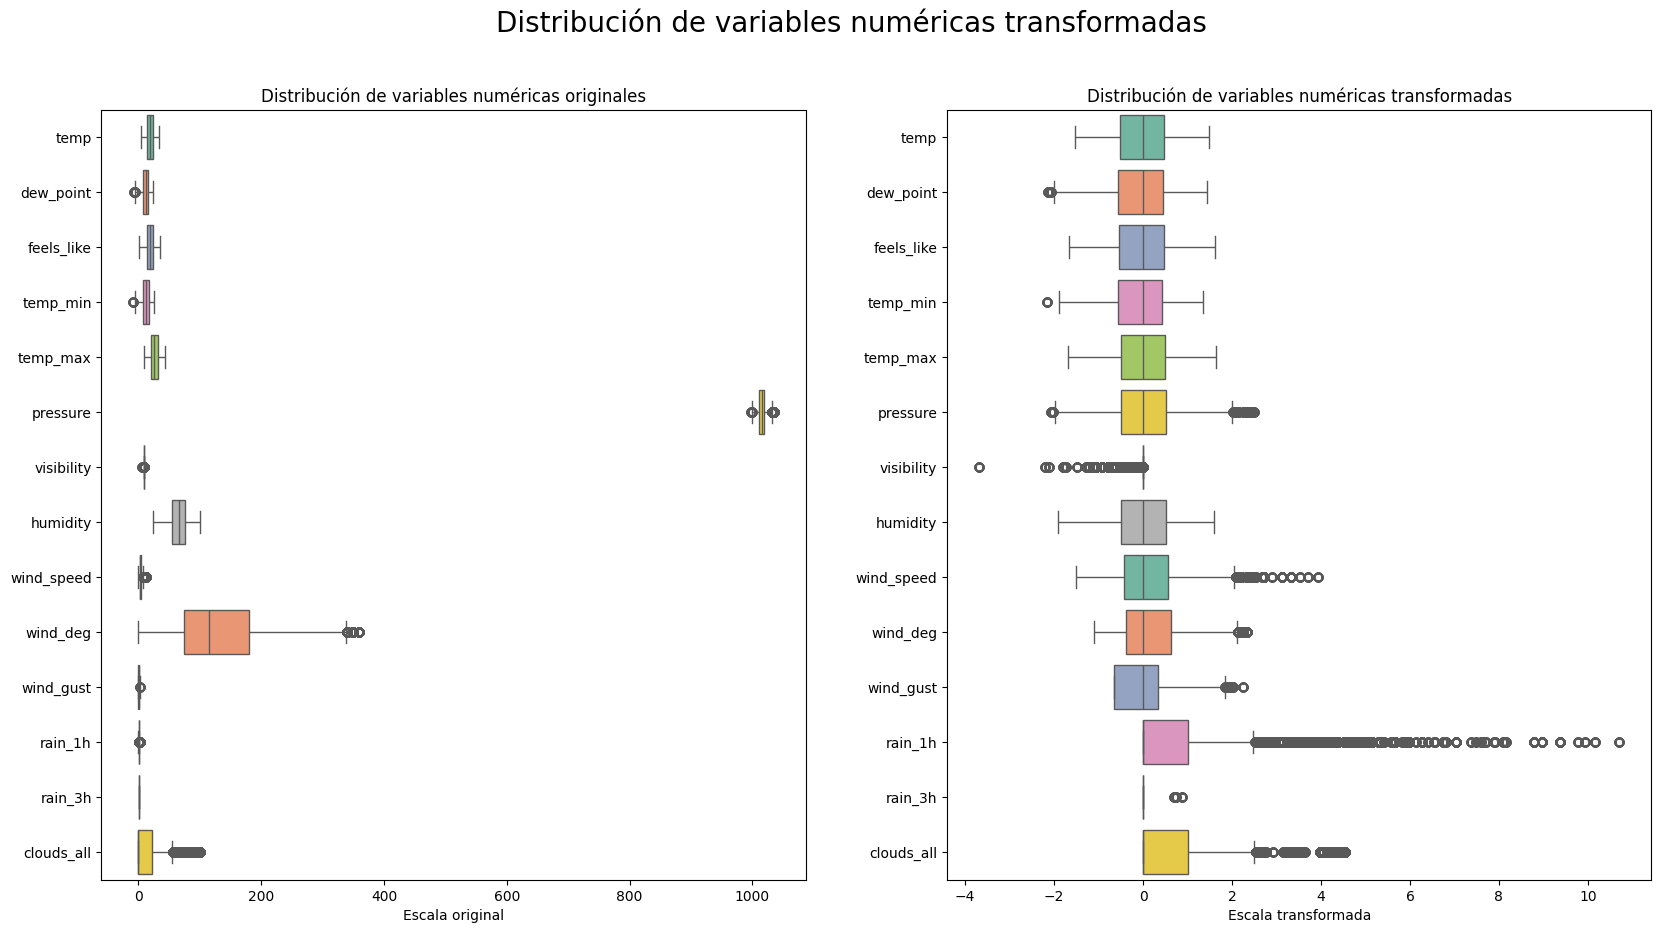

In [521]:
#variables numerias dde x_train
numericas = X.select_dtypes(include='number').columns

adaptar = lambda x: x.replace('num_mean__','') if 'num_mean' in x else x.replace('num_zero__','')
columnasOriginales = [adaptar(x) for x in numericas]

fig, ax = plt.subplots(1,2, figsize=(20, 10))
fig.suptitle("Distribución de variables numéricas transformadas", fontsize=20)

sns.boxplot(data = X_train[numericas], orient='h', palette='Set2', ax=ax[0])
ax[0].set_xlabel("Escala original")
ax[0].set_title("Distribución de variables numéricas originales")
#ax[0].set_title("Distribución de variables numéricas originales")

sns.boxplot(data=X_train_tr[numericas], orient='h', palette='Set2', ax=ax[1])
#quitar labels eje y
#ax[1].set_yticks([])
ax[1].set_xlabel("Escala transformada")
ax[1].set_title("Distribución de variables numéricas transformadas")
#plt.title("Distribución de variables numéricas transformadas")

In [523]:
y_train

0           NaN
1         33.57
2         11.31
3         13.95
4         20.64
          ...  
128478      NaN
128479      NaN
128480      NaN
128481      NaN
128482      NaN
Name: Kg, Length: 127664, dtype: float64

In [525]:
y_train = y_train.fillna(0)

In [526]:
# Guardar el DataFrame limpio en un nuevo archivo CSV
X_train_tr['Kg'] = y_train.values

X_train_tr.to_csv('dataset_train.csv', sep=';', index=False)

# Arquitectura

No tengo muy definida esta parte pero sí una idea de lo que quiero hacer. Lo detallo a continuación:

Dada una tabla como esta:

| Fecha      | x1 | x2 | Sabor   | Kg |
|------------|----|----|---------|----|
| 11/04/2025 | 5  | 4  | Sabor 1 | 54 |
| 11/04/2025 | 5  | 4  | Sabor 2 | 23 |
| 11/04/2025 | 5  | 4  | Sabor 3 | 12 |

la idea es predecir a 14 días con una ventana $n$ de contexto (por ejemplo $n$ = 7). Se tomarán los últimos $n$ días y, adquiriendo dichos kg como variables, se realizará la predicción de Kg día a día hasta llegar a 14 días.

Un enfoque es hacerlo sin que las predicciones se agreguen como datos. Este enfoque tiene la ventaja de que no será necesario conocer el valor de todas las variables en el futuro, solo se predeciran los kg. Una segunda forma de pensarlo es realizando predicciones que tengan en cuenta las predicciones anteriores y comiencen a insertar filas al dataset (filas correspondientes al futuro). 

Por ahora me enfocaré en el primero ya que no cuento con una api para consultar el tiempo en los próximos días.

La tabla objetivo entonces tendría un formato como el siguiente:
| Fecha      | x1 | x2 | Sabor   | Kg | Kg hace 1 día | Kg hace 2 días | ... | Kg hace $n$ días  |
|------------|----|----|---------|----|---------------|----------------|-----|-------------------|
| 11/04/2025 | 5  | 4  | Sabor 1 | 54 |     23        |        24      | ... |       $k_{1}$     |
| 11/04/2025 | 5  | 4  | Sabor 2 | 23 |     56        |        65      | ... |       $k_{2}$     |
| 11/04/2025 | 5  | 4  | Sabor 3 | 12 |     89        |        56      | ... |       $k_{3}$     |

Donde la variable a predecir seguirá siendo Kg con el dato adicional de los kilogramos vendidos para el sabor seleccionado en los ultimos $n$ días y x1 y x2 corresponden a las distintas variables relacionadas al clima.

In [ ]:
dias_contexto = 15  # Número de días a considerar antes
dias_a_predecir = 14

#Ordenar df
df_melt = df_melt.sort_values(by=['Sabor', 'dt_iso'])

#Crear Variables de Contexto
for i in range(1, dias_contexto+1):
    df_melt[f'Kg_{i}'] = df_melt.groupby('Sabor')['Kg'].shift(i)

In [ ]:
#Donde kg_10 sea nulo
#df_melt[df_melt['Kg_10'].isnull() & df_melt['Kg_7'].isnull()][['dt_iso','Sabor', 'Kg', 'Kg_7', 'Kg_10']]

df_melt[(df_melt['Sabor'] == 'Sabor 17') & (df_melt['Kg_10'].isnull())][['dt_iso','Sabor', 'Kg', 'Kg_7', 'Kg_10']].tail(10)

,dt_iso,Sabor,Kg,Kg_7,Kg_10
34512,2024-12-17,Sabor 17,NaN,5.59,NaN
34513,2024-12-18,Sabor 17,NaN,5.90,NaN
34522,2024-12-27,Sabor 17,5.56,NaN,NaN
34523,2024-12-28,Sabor 17,NaN,6.67,NaN
34525,2024-12-30,Sabor 17,22.21,3.19,NaN
34531,2025-01-15,Sabor 17,5.93,8.33,NaN
34533,2025-01-17,Sabor 17,6.66,5.73,NaN
34537,2025-01-21,Sabor 17,10.89,6.63,NaN
34539,2025-01-23,Sabor 17,6.42,18.10,NaN
34546,2025-01-30,Sabor 17,5.75,6.42,NaN


-----------------

El modelo a utilizar será una RNN que captura patrones de secuencia y permite la predicción de varios valores.
Por este motivo no será necesario adaptar la tabla como se mencionó más arriba.
El formato que se seguirá usando es el de: 


| Fecha      | x1 | x2 | Sabor   | Kg |
|------------|----|----|---------|----|
| 11/04/2025 | 5  | 4  | Sabor 1 | 54 |
| 11/04/2025 | 5  | 4  | Sabor 2 | 23 |
| 11/04/2025 | 5  | 4  | Sabor 3 | 12 |

In [ ]:
X_train_tr

,rain_1h,rain_3h,temp,dew_point,feels_like,temp_min,temp_max,pressure,visibility,humidity,...,Sabor_Sabor 62,Sabor_Sabor 63,Sabor_Sabor 64,Sabor_Sabor 7,Sabor_Sabor 8,Sabor_Sabor 9,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano
0,0.000000,0.0,0.676409,0.911399,0.784951,0.633919,0.590326,-1.063278,0.000000,0.139535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.311575,0.0,0.768239,1.053384,0.837929,1.047570,0.377098,-1.208506,-0.000050,0.348837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.649653,0.0,0.217038,0.655573,0.249699,0.530507,-0.177690,-0.238589,-0.000100,0.674419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.0,0.060900,0.185583,0.067208,-0.089969,0.267522,0.513485,-0.000050,0.232558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.665132,0.0,0.610747,0.737199,0.662714,0.624612,0.645607,-0.077801,0.000000,0.046512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127659,0.000000,0.0,-0.745609,-1.763019,-0.786076,-1.433299,-0.603159,-0.165975,0.000000,-1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
127660,0.000000,0.0,-0.867846,-1.818583,-0.875030,-1.433299,-0.384008,0.057054,0.000000,-1.279070,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
127661,0.000000,0.0,-0.535605,-1.501913,-0.581960,-1.165460,-0.054294,-0.103734,0.000000,-1.186047,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
127662,0.000000,0.0,-0.527348,-1.284116,-0.568012,-0.917270,-0.216190,-0.663900,-0.105361,-1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X_train_tr.shape

(127664, 98)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Definir el modelo LSTM
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_tr.shape[1], X_train_tr.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(14)  # Salida para predecir 14 días
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Resumen del modelo
model.summary()

IndexError: tuple index out of range

In [ ]:
# Entrenar el modelo
history = model.fit(
    X_train_tr, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

In [ ]:
# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss}, MAE: {mae}")

In [ ]:
# Realizar predicciones para los próximos 14 días
predictions = model.predict(X_test)
print(predictions)

# Adecuacion text

In [527]:
# Aplciar pipeline a X_test
X_test_tr = pipeline.named_steps['preprocessor'].transform(X_test)
X_test_tr = X_test_tr.toarray()
X_test_tr = pd.DataFrame(X_test_tr, columns=column_names)
X_test_tr.head()

,rain_1h,rain_3h,temp,dew_point,feels_like,temp_min,temp_max,pressure,visibility,humidity,...,Sabor_Sabor 62,Sabor_Sabor 63,Sabor_Sabor 64,Sabor_Sabor 7,Sabor_Sabor 8,Sabor_Sabor 9,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano
0,0.0,0.0,-1.217737,-1.720922,-1.219632,-1.743537,-1.041461,2.349585,9990.78966,-0.534884,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,-1.122280,-1.999322,-1.124608,-1.743537,-0.658440,1.919087,9990.78966,-1.023256,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,-0.775448,-1.719760,-0.846089,-1.123061,-0.603159,1.286307,9990.78966,-1.441860,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,-0.621014,-1.279998,-0.716979,-0.812823,-0.281343,0.357884,9990.78966,-1.069767,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,-0.056007,-0.407111,-0.095265,-0.114788,0.277394,-0.492739,9990.78966,-0.441860,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [529]:
y_test = y_test.fillna(0)
X_test_tr['Kg'] = y_test.values

X_test_tr.to_csv('dataset_test.csv', sep=';', index=False)